In [17]:
## DESCRIPTION DU PROGRAMME :
# Ce programme applique la méthode K-means à un ensemble de données GPS localisées 
# dans un périmètre choisi et affiche les zones obtenues.

# Dans le cadre du projet, on affiche l'ensemble des données récoltées sur le campus de l'Ecole
# Centrale de Lyon sur une carte du campus afin de déterminer des zones de fréquentation du 
# campus à partir des données.

## PARAMETRES POUVANT ETRE CHANGES : 
# La liste L des points considérés
# Le périmètre qui délimite la zone où l'on considère les points
# datafile3 qui correspond à l'image de fond ainsi que les coordonnéees associées à la carte
# nombre_de_zones (jusqu'à 8 pour l'affichage avec des couleurs)
# la graine de la fonction random.seed

In [18]:
## Quelques imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
from operator import truediv

In [19]:
##Créer une liste des toutes les points [latitude, longitude] de la collecte situés aux alentours du campus
L=["histo_BAI_Yue.json","histo_Belhouari_Ahmed.json","histo_Chalicarne_Raphael.json","histo_Colas_Jules.json","histo_Fregosi_Guillaume.json","histo_Hanser_Corentin.json","histo_Kaprelian_Theo.json","histo_Lyon_Fabien.json","histo_Perrine_Pauline.json","histo_Qifei_Li.json"]

In [20]:
## On définit un périmètre rectangulaire autour du campus de l'ECL (à l'aide d'Open Street Maps)
lat_nord = 45.78603
lat_sud = 45.78041
long_ouest = 4.76471
long_est = 4.77209

perimetre = [long_ouest, long_est, lat_sud, lat_nord] 
#correspond aux bornes de la carte-petite-centrale : pris comme perimetre du campus

Points = []
long, lat = [], []
for e in L:
    f=open(e)
    df = pd.read_json(f)
    donnee=df.get("locations")
    for i in range(len(donnee)):
        lo=donnee[i]["longitudeE7"]/1e7
        la=donnee[i]["latitudeE7"]/1e7
        if (lo >= perimetre[0] and lo <= perimetre[1] and la >= perimetre[2] and la <= perimetre[3]) : #points dans le perimetre
            Points.append(np.array([[lo],[la]]))
            long.append(lo)
            lat.append(la)
f.close()

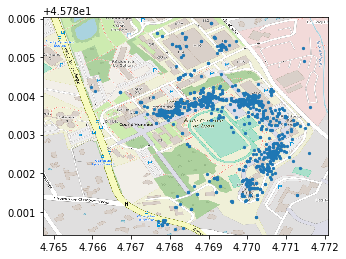

In [21]:
## Affichage des points sur une carte du campus

plt.figure(1)

datafile3 = 'carte_centrale_petite.png'
img3 = plt.imread(datafile3)

plt.scatter(long,lat, s=5, zorder=1)
plt.imshow(img3,zorder=0,extent = [4.76471,4.77209,45.78041,45.78603])

plt.show()

In [22]:
## Délimiter un périmètre où choisir les conditions initiales des centres des zones
perimetre_centres= [min(long), max(long), min(lat), max(lat)]

In [23]:
## Choisir les conditions initiales de la méthode : le nombre de zones et le centre de ces zones
nombre_de_zones = 7     #choix du nombre de zones à calculer

# CHANGER LA GRAINE POUR CHANGER LES CONDITIONS INITIALES
# on utilise la fonction random.seed pour pouvoir retrouver certains des résultats
np.random.seed(84)

centres_long = [] 
centres_lat = []
for i in range(nombre_de_zones) :
    longitude = perimetre_centres[0]+ (perimetre_centres[1]-perimetre_centres[0])*rnd.random()
    latitude = perimetre_centres[2]+ (perimetre_centres[3]-perimetre_centres[2])*rnd.random()
    centres_long.append(longitude)
    centres_lat.append(latitude)
    
#conditions initiales : centres des zones dans le perimetre chacun définis par un vecteur 
# array([[latitude], [longitude]]).

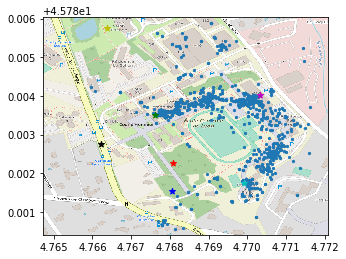

In [24]:
## Affichage des centres sur la carte du campus avec un code couleur

c_long, c_lat = [], []
for i in range(nombre_de_zones) :
    c_long.append([centres_long[i]])
    c_lat.append([centres_lat[i]])

plt.figure(2)

plt.imshow(img3,zorder=0,extent = [4.76471,4.77209,45.78041,45.78603])

plt.scatter(long,lat, s=5, zorder=1)

couleurs_zones = ['r', 'b', 'y', 'g', 'm', 'c', 'k', 'w'] #couleurs disponibles pour les zones (8 maximum)
for i in range(nombre_de_zones) :
    plt.scatter(centres_long[i], centres_lat[i], s=40, c=couleurs_zones[i], marker ='*', zorder = 2)

plt.show()

In [25]:
##Calcul des points appartenant à chaque zone pour une étape d'itération : 

# Pour chaque points on calcule le centre qui est le plus proche et on l'associe à la zone correspondante.

def zones(Points, nombre_de_zones, centres_long, centres_lat):
    Zones = [[] for i in range(nombre_de_zones)] #contiendra la liste des points-vecteurs appartenant à une zone d'indice i

    for i in range(len(Points)):
        long_p = Points[i][0]
        lat_p = Points[i][1]
        distances_aux_centres= []
        for j in range(nombre_de_zones):
            distance = np.square((Points[i][0]-centres_long[j])**2+(Points[i][1]-centres_lat[j])**2)
            distances_aux_centres.append(distance)
        Numero_zone = distances_aux_centres.index(min(distances_aux_centres))
        Zones[Numero_zone].append(Points[i])
        plt.scatter(long_p, lat_p, s=5, c=couleurs_zones[Numero_zone] , zorder=1)
    return Zones


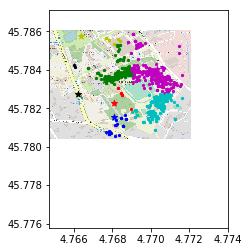

In [26]:
## Représentation des points par zones correspondant aux plus proches centres
plt.figure(3)

Zones = zones(Points, nombre_de_zones, centres_long, centres_lat)

plt.imshow(img3,zorder=0,extent = [4.76471,4.77209,45.78041,45.78603])

for i in range(nombre_de_zones) :
    plt.scatter(centres_long[i], centres_lat[i], s=40, c=couleurs_zones[i], marker ='*', zorder = 2)

plt.show()

In [27]:
## Calcul des nouveaux centres des zones pour une étape d'itération :

def new_centres(Zones, nombre_de_zones, centres_long, centres_lat) :
    c_long, c_lat = centres_long, centres_lat
    for j in range(nombre_de_zones):
        n = len(Zones[j])
        if n!=0 :
            moy_long = truediv(sum(Zones[j])[0],n)
            moy_lat = truediv(sum(Zones[j])[1],n)
            moy_long = moy_long.tolist()[0]
            moy_lat = moy_lat.tolist()[0]
            c_long[j] = moy_long
            c_lat[j] = moy_lat
    return c_long, c_lat

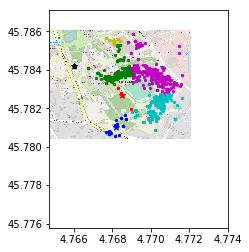

In [28]:
## Représentation des nouveaux centres calculés
plt.figure(4)

Zones = zones(Points, nombre_de_zones, centres_long, centres_lat)

nvx_centres_long, nvx_centres_lat = new_centres(Zones, nombre_de_zones, centres_long, centres_lat)

nvx_c_long, nvx_c_lat = [], []
for i in range(nombre_de_zones):
    nvx_c_long.append([nvx_centres_long[i]])
    nvx_c_lat.append([nvx_centres_lat[i]])

plt.imshow(img3,zorder=0,extent = [4.76471,4.77209,45.78041,45.78603])

for i in range(nombre_de_zones) :
    plt.scatter(nvx_c_long[i], nvx_c_lat[i], s=40, c=couleurs_zones[i], marker ='*', zorder = 2)

plt.show()

In [29]:
## Programme d'itération du calcul des zones et des centres associés

def K_means(Points, nombre_de_zones, centres_long, centres_lat):
    barycentres_long, barycentres_lat = centres_long, centres_lat
    nvx_centres_long,  nvx_centres_lat = [], []
    count = 0
    # Critère de fin d'itération : quand tous les centres restent fixent entre 2 itérations
    while (barycentres_long != nvx_centres_long) or (barycentres_lat != nvx_centres_lat) or (count == 100) :
        Zones = zones(Points, nombre_de_zones, centres_long, centres_lat)
        c_long, c_lat = new_centres(Zones, nombre_de_zones,centres_long,  centres_lat)
        barycentres_long, nvx_centres_long = nvx_centres_long, c_long
        barycentres_lat, nvx_centres_lat = nvx_centres_lat, c_lat
        count += 1
    return nvx_centres_long, nvx_centres_lat, count

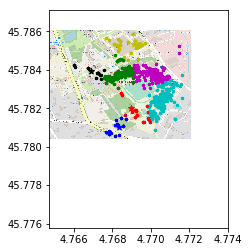

In [30]:
## Tracé de la figure de fin sur une carte du campus : centres et zones
plt.figure(5)

barycentres_long, barycentres_lat, compteur = K_means(Points, nombre_de_zones, centres_long, centres_lat)

Zones = zones(Points, nombre_de_zones, barycentres_long, barycentres_lat)

baryc_long, baryc_lat = [], []
for i in range(nombre_de_zones):
    baryc_long.append([barycentres_long[i]])
    baryc_lat.append([barycentres_lat[i]])

plt.imshow(img3,zorder=0,extent = [4.76471,4.77209,45.78041,45.78603])

for i in range(nombre_de_zones) :
    plt.scatter(baryc_long[i], baryc_lat[i], s=40, c=couleurs_zones[i], marker ='*', zorder = 2)

plt.show()

In [31]:
## Vérifier le nombre d'itérations de la méthode 
compteur

2